2012
"Carassius gibelio recorded by Sasha & LA"
"Recorded at 17:14:07 of 05-23-2022"
"Number of channels",1
"Start time",0
"Sweep Duration",700
"Sweep period",701
"Point time",2
"No of averaged sweeps",1
"Stim1_Delay",1000
"Stim1_Duration",16
"Stim1_Period",5000
"Stim2_Delay",5000
"Stim2_Duration",20000
"Stim2_Period",900000
"Stim3_Delay",200
"Stim3_Duration",2
"Stim3_Period",500000
"adapt memory protocol  flash - ch1 (0-0), step ch 2 (0-6) 20 s ch 3 - as prev  "


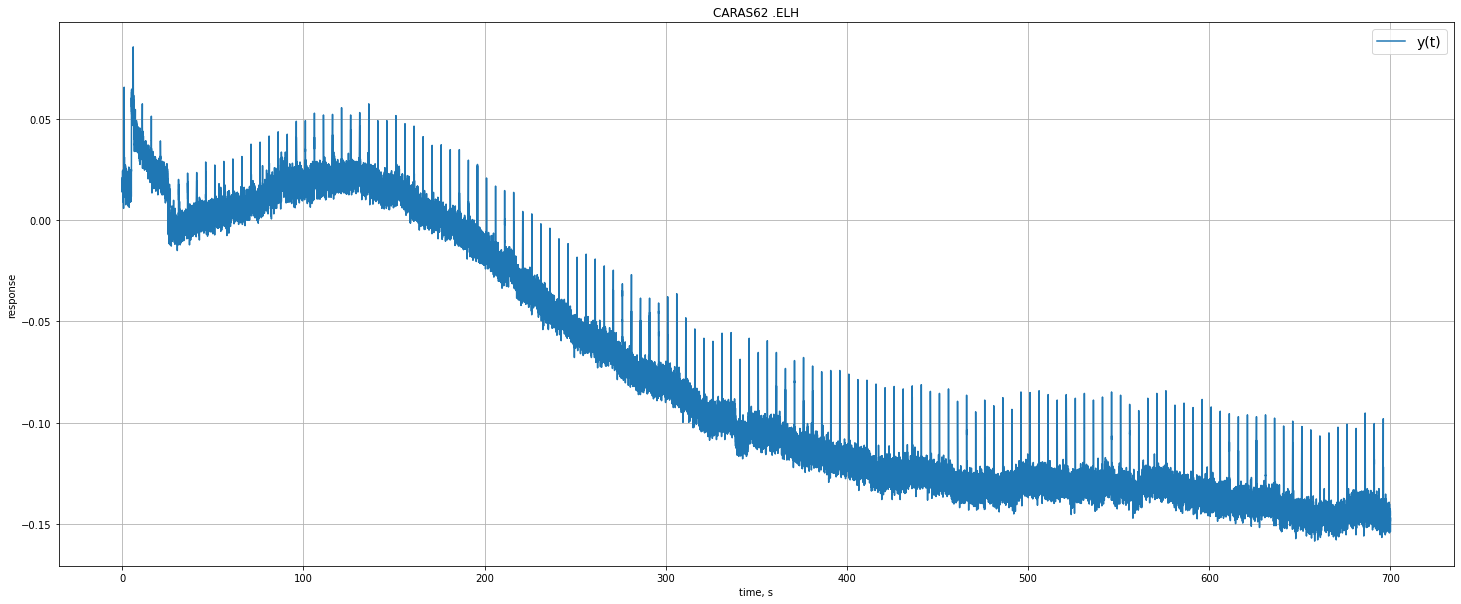

In [37]:
import matplotlib.pyplot as plt
import numpy as np


input_dir = './data/'
filename = 'CARAS62 .ELH'
freq = 500

with open(input_dir + filename, 'r', encoding='utf-8') as file:
    info = []
    line = file.readline().strip()
    while line[:2] != '""':
        info.append(line)
        line = file.readline().strip()
    info = '\n'.join(info)
    y = np.array([float('0' if line == '.\n' else line) for line in file])

n = y.size
t = np.linspace(0, (n - 1) / freq, n)

print(info)
fig, ax = plt.subplots()
ax.plot(t, y, label='y(t)')
fig.set_figwidth(25)
fig.set_figheight(10)
ax.set_xlabel('time, s')
ax.set_ylabel('response')
ax.set_title(filename)
ax.legend(prop={"size": 14})
ax.grid()

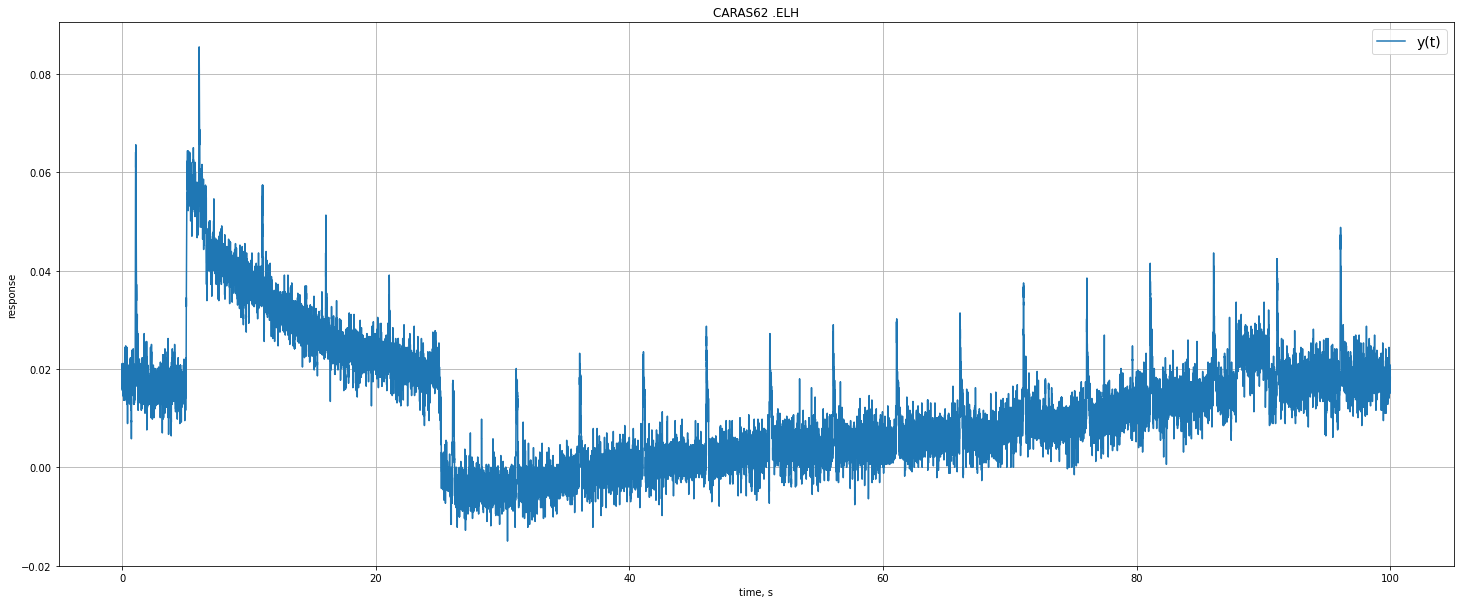

In [38]:
fig, ax = plt.subplots()
ax.plot(t[:100 * freq], y[:100 * freq], label='y(t)')
fig.set_figwidth(25)
fig.set_figheight(10)
ax.set_xlabel('time, s')
ax.set_ylabel('response')
ax.set_title(filename)
ax.legend(prop={"size": 14})
ax.grid()